# Knapsack Problem with GA

**Author:** Gonçalo Oliveira Silva  
**Date:** 2025-07-14  
**GitHub:** [goncalooliveirasilva](https://github.com/goncalooliveirasilva)  
**License:** MIT

This notebook demonstrates how to use a **Genetic Algorithm (GA)** to solve the classic [**Knapsack Problem**](https://en.wikipedia.org/wiki/Knapsack_problem) - an optimization problem where we aim to **maximize the total value** of selected items without exceeding the **knapsack's weight capacity**. In the end, this solution is also compared with the brute force approach.

In [264]:
import random
import time
from collections import Counter
import matplotlib.pyplot as plt
from prettytable import PrettyTable

KNAPSACK_CAPACITY = 1500

MIN_VALUE = 10      # Minimum value of an item
MAX_VALUE = 500     # Maximum value of an item
MIN_WEIGHT = 1      # Minimum weight of an item
MAX_WEIGHT = 15     # Maximum weight of an item

POPULATION = 30     # Population size

### Item class
This section of code defines the `Item` class, which represents a single item that can be placed in the knapsack. 
Each item has:
 - `name` - a string identifying the item
 - `value` - a numeric value representing how valuable the item is
 - `weight` - a numeric value indicating how heavy the item is

A list of items that can be changed is also defined. The algorithm will try different combinations of these items to maximize the total value while staying under the weight limit.

In [265]:
class Item():
    '''Item to put into the knapsack.'''

    def __init__(self, name: str, value: float, weight: float):
        self.name = name
        self.value = value
        self.weight = weight


def print_items(items):
    '''Prints items information in a table.'''
    table = PrettyTable()
    table.field_names = ["Name", "Value", "Weight"]
    for item in items:
            table.add_row([item.name, item.value, item.weight])
    print(table)


ITEMS = [
    Item("Laptop", 1000, 400),
    Item("Smartphone", 800, 180),
    Item("Headphones", 200, 250),
    Item("Water Bottle", 50, 500),
    Item("Camera", 600, 300),
    Item("Notebook", 20, 100),
    Item("Tablet", 400, 350),
    Item("Power Bank", 100, 250),
    Item("Sunglasses", 120, 80)
]

NUM_ITEMS = len(ITEMS)
print_items(ITEMS)

+--------------+-------+--------+
|     Name     | Value | Weight |
+--------------+-------+--------+
|    Laptop    |  1000 |  400   |
|  Smartphone  |  800  |  180   |
|  Headphones  |  200  |  250   |
| Water Bottle |   50  |  500   |
|    Camera    |  600  |  300   |
|   Notebook   |   20  |  100   |
|    Tablet    |  400  |  350   |
|  Power Bank  |  100  |  250   |
|  Sunglasses  |  120  |   80   |
+--------------+-------+--------+


### Knapsack class
This class models a potential solution.  
Each `knapsack` object holds a **chromosome**, which is a list of boolean values.  
Each index represents whether an item from the `ITEMS` list is included (`True`) or not (`False`) in the knapsack. 

##### `create_chromosome()`
When the population is started, the chromosome is calculated (using `create_chromosome()`) since none are provided, as happens in subsequent generations.

##### `compute_fitness()`
This function evaluates a knapsack's fitness (how "good" the current selection is):
 - It sums up the weights and values of all items marked `True` in the chromosome.
 - If the total weight exceeds the allowed capacity (`KNAPSACK_CAPACITY`), it returns `0` (invalid solution).
 - Otherwise, the **fitness equals the total value** of selected items.

##### `crossover()`
A **single crossover point** is selected, and the first part comes from one parent and the second from the other.

##### `mutate()`
Each gene has a chance to **flip** (i.e., `True` becomes `False` and vice versa). This introduces randomness into the population to help the algorithm explore new solutions.

In [255]:
class Knapsack():
    '''Knapsack to put some items.'''

    def __init__(self, chromosome : list[bool] = None):
        self.chromosome = chromosome
        if self.chromosome is None:
            self.chromosome = self.create_chromosome()
        self.fitness = self.compute_fitness()


    def create_chromosome(self):
        '''Creates the chromosome of a knapsack.'''
        return [random.choice([True, False]) for _ in range(NUM_ITEMS)]


    def compute_fitness(self):
        '''Calculates the fitness of a knapsack.'''
        total_weight = sum([ITEMS[i].weight for i in range(NUM_ITEMS) if self.chromosome[i]])
        total_value = sum([ITEMS[i].value for i in range(NUM_ITEMS) if self.chromosome[i]])

        # If total weight is higher than the knapsack's capacity,
        # the items combination is not possible
        if total_weight > KNAPSACK_CAPACITY:
            return 0

        return total_value


    def crossover(self, knapsack):
        '''
        Creates a new knapsack based on two existing knapsacks
        by combining two halves, one from each parent knapsack.
        '''
        break_point = random.randint(1, NUM_ITEMS - 1)
        child_chromosome = self.chromosome[0:break_point]
        child_chromosome.extend(knapsack.chromosome[break_point:])
        return Knapsack(child_chromosome)


    def mutate(self, l = 0.1):
        '''Introduces random mutations.'''
        for i in range(NUM_ITEMS):
            if random.random() < l:
                self.chromosome[i] = not self.chromosome[i]

### Main loop
The `main()` function is the core of the genetic algorithm. It simulates the evolutionary process over a fixed number of generations - in this case, **20**. In many real-world evolutionary algorithms, it's often unclear when to stop. A stopping condition could be:
- when a population stops improving
- when a certain fitness level is reached
- or simply a fixed number of generations

For simplicity, this implementation uses a fixed generation count (**20 generations**), which is enough to observe evolution in action and identify good solutions. I'll show you a graph in a moment, where I ran the algorithm with different generation limits. Keep in mind that this algorithm is **not deterministic** - meaning that if you run it again, you might get slightly different results due to the randomness involved in selection, crossover and mutation.

In [256]:
def create_initial_population():
    '''Creates the initial population of knapsacks.'''
    return [Knapsack() for _ in range(POPULATION)]


def print_stats(logs : list[tuple]):
    '''Prints some information in a table.'''
    table = PrettyTable()
    headers = ["Gen."]
    headers.extend([item.name for item in ITEMS])
    headers.extend(["T.W.", "T.V.", "F."])
    table.field_names = headers
    for i, (ch, fit, val, w) in enumerate(logs):
        row = [f"{i+1}"]
        for gene in ch:
            row.append("X" if gene else " ")
        row.extend([w, val, fit])
        table.add_row(row)
    print(table)



def ga_knapsack(max_generations = 20):
    '''Main loop.'''
    gen = 1
    logs : list[tuple] = []

    # Initialize population
    population = create_initial_population()

    # Restrict to a maximum number of generations
    while gen <= max_generations:
        population.sort(key=lambda knap: knap.fitness, reverse=True)

        # Best solution of the generation
        best = population[0]

        # Preserve best 2 solutions
        new_gen = population[:2]

        # Top 50% for crossover
        top_half = population[:POPULATION // 2]

        for _ in range(POPULATION - 2):
            knapsack_a = random.choice(top_half)        # Parent solution 1
            knapsack_b = random.choice(top_half)        # Parent solution 2
            child = knapsack_a.crossover(knapsack_b)
            child.mutate()
            new_gen.append(child)

        gen += 1
        population = new_gen

        total_weight = sum([ITEMS[i].weight for i in range(NUM_ITEMS) if best.chromosome[i]])
        total_value = sum([ITEMS[i].value for i in range(NUM_ITEMS) if best.chromosome[i]]) 
        logs.append((best.chromosome, best.fitness, total_value, total_weight))
    return logs

logs = ga_knapsack()

### Results

The following table shows the results obtained over **20 generations**. Each row represents a solution from one generation. An `X` indicates that the corresponding item is included in the knapsack for that generation. At the end of each row, you'll find the **Total Weight**, **Total Value** and **Fitness** of the selected item combination. 

We can observe that the solution stabilizes after **generation 11** - from that point on, the selected items remain the same. This suggests that the algorithm has likely converged to a good (though not necessarily optimal) solution.

The best solution found includes a combination of items that bring the total weight to **1480**, just under the assumed **maximum knapsack capacity of 1500**, and yields a **total value (fitness) of 3000**.

In [257]:
print_stats(logs=logs)

+------+--------+------------+------------+--------------+--------+----------+--------+------------+------------+------+------+------+
| Gen. | Laptop | Smartphone | Headphones | Water Bottle | Camera | Notebook | Tablet | Power Bank | Sunglasses | T.W. | T.V. |  F.  |
+------+--------+------------+------------+--------------+--------+----------+--------+------------+------------+------+------+------+
|  1   |   X    |     X      |     X      |              |        |          |   X    |            |            | 1180 | 2400 | 2400 |
|  2   |   X    |     X      |     X      |              |        |          |   X    |            |            | 1180 | 2400 | 2400 |
|  3   |   X    |     X      |     X      |              |        |          |   X    |            |            | 1180 | 2400 | 2400 |
|  4   |   X    |     X      |     X      |              |        |          |   X    |            |            | 1180 | 2400 | 2400 |
|  5   |        |     X      |     X      |            

#### Running multiple times

The scatter plot bellow illustrates the **best solution** found in each of the algorithm's runs. Each point represents a solution, where the **x-axis** is the **total weight** and the **y-axis** is the **total value** of the selected items in that run.

- The **color intensity** of a point reflects how **frequently** that specific solution appeared across all runs.
- **Darker points** indicate that the algorithm found the same solution **multiple times**, suggesting it's a consistently strong candidate.
- This variation highlights the **non-deterministic** nature of genetic algorithms - while some runs converge to the same optimal solution, other may explore different (possibly suboptimal) combinations.

In this example, we can clearly see that one solution with value 1480 and max weight 3000 was repeatedly found (**24 times**), which suggests it may be a **near-optimal or optimal configuration** for the problem.


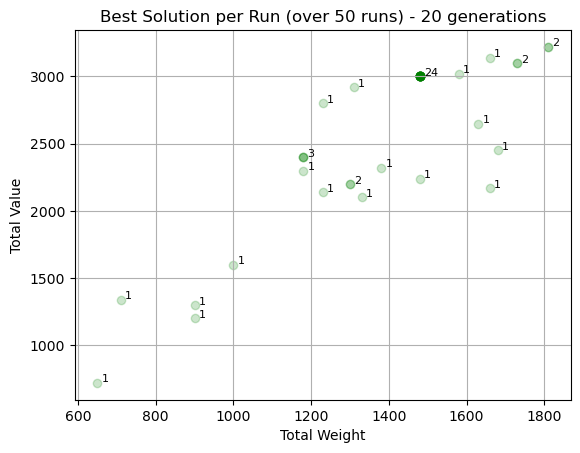

In [272]:
N = 50
weights = []
values = []
for _ in range(N):
    logs = ga_knapsack()
    best = logs[-1]
    weights.append(best[3])
    values.append(best[2])

points = list(zip(weights, values))


plt.scatter(weights, values, alpha=0.2, color='green')
plt.title(f"Best Solution per Run (over {N} runs) - 20 generations")
plt.xlabel("Total Weight")
plt.ylabel("Total Value")

point_counts = Counter(points)
for (x, y), count in point_counts.items():
    plt.text(x + 11, y + 5, f"{count}", fontsize=8)

plt.grid(True)

The graph bellow shows how the best solution varies as we increase the number of generations. Each point represents the best solution found when running the genetic algorithm with a specific number of generations.  
While we might expect that **more generations would consistently lead to better solutions**, **this is not always the case**. Because this algorithm is **stochastic** (i.e., it involves randomness), it can sometimes find high-quality solutions even with a low number of generations - and other times it may not improve much despite running longer.  
That said, increasing the number of generations **generally gives the algorithm more opportunities to evolve better item combinations**, but due to its non-deterministic nature, **the results can vary**, and the improvement is not guaranteed to be linear or consistent.

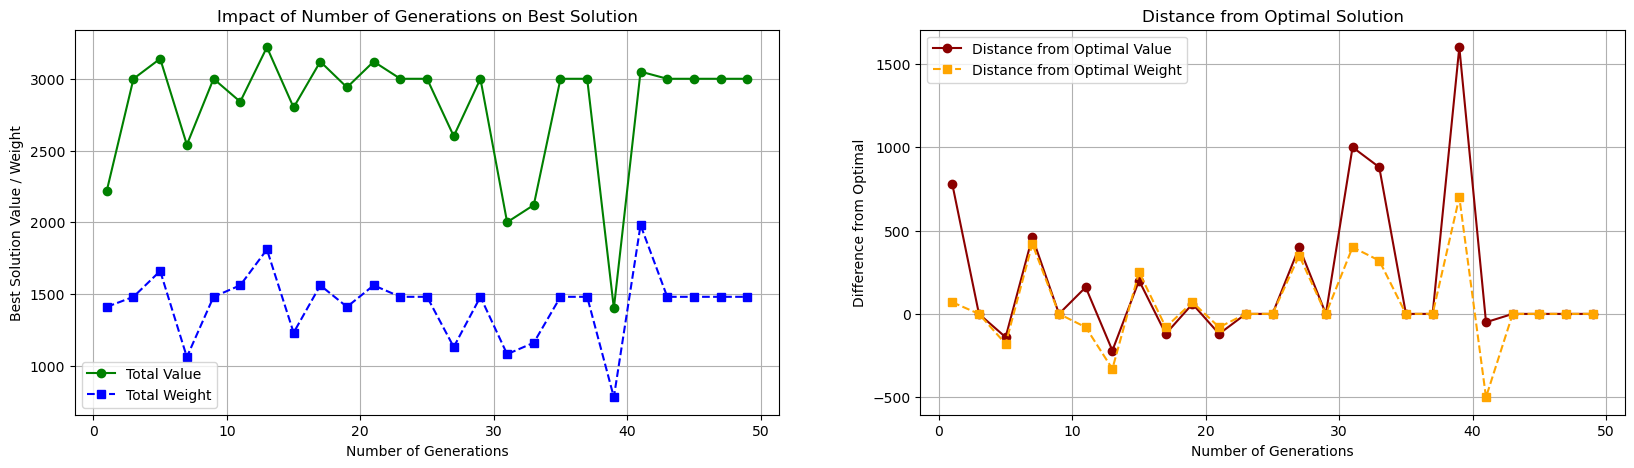

In [259]:
NUM_GEN = 50
step = 2
gen_counts = []
best_values = []
best_weights = []
for gen in range(1, NUM_GEN + 1, step):
    logs = ga_knapsack(gen)
    best = logs[-1]
    gen_counts.append(gen)
    best_values.append(best[2])
    best_weights.append(best[3])

OPTIMAL_VALUE = 3000
OPTIMAL_WEIGHT = 1480

value_distances = [OPTIMAL_VALUE - val for val in best_values]
weight_distances = [OPTIMAL_WEIGHT - w for w in best_weights]

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(gen_counts, best_values, marker='o', label='Total Value', color='green')
plt.plot(gen_counts, best_weights, marker='s', label='Total Weight', color='blue', linestyle='--')
plt.title("Impact of Number of Generations on Best Solution")
plt.xlabel("Number of Generations")
plt.ylabel("Best Solution Value / Weight")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(gen_counts, value_distances, marker='o', label='Distance from Optimal Value', color='darkred')
plt.plot(gen_counts, weight_distances, marker='s', label='Distance from Optimal Weight', color='orange', linestyle='--')
plt.title("Distance from Optimal Solution")
plt.xlabel("Number of Generations")
plt.ylabel("Difference from Optimal")
plt.legend()
plt.grid(True)

### Comparison with brute force approach

Each item in the problem has two possible choices: either **include** it in the knapsack or **exclude** it.  
Therefore, for **n items**, the total number of possible combinations is:
$$
\underbrace{2 \times 2 \times \dots \times 2}_{n\text{ times}} = 2^n
$$
This means there are $2^n$ different ways to choose items. The brute-force approach works by checking **all these combinations**. Each combination can be represented by a binary number from $0$ to $2^n-1$. For example:
- $010101$ - each binary digit tells whether the corresponding item is **included (1)** or **excluded (0)**

The algorithm converts each number to a binary string, and then to a list of $0$'s and $1$'s (`combination`). It calculates the total weight and value for each combination and keeps track of the best one found.

In [260]:
def knapsack_brute_force():
    '''Brute-force knapsack solution.'''
    best_value = 0
    best_combination = []

    for i in range(2**NUM_ITEMS):
        combination = [int(bit) for bit in bin(i)[2:].zfill(NUM_ITEMS)]
        total_weight = 0
        total_value = 0
        for j in range(NUM_ITEMS):
            if combination[j] == 1:             # The item is included
                total_weight += ITEMS[j].weight
                total_value += ITEMS[j].value

        if total_weight <= KNAPSACK_CAPACITY and total_value > best_value:
            # We found a better combination
            best_value = total_value
            best_combination = combination

    # Indices of selected items in the best combination
    selected = [i for i in range(NUM_ITEMS) if best_combination[i] == 1]
    return best_value, selected

As we can see, the brute-force algorithm arrives at the **same optimal solution** found by the genetic algorithm, confirming its correctness.

In [261]:
best_value, selected_idx = knapsack_brute_force()
weight = sum([ITEMS[i].weight for i in selected_idx])
print("Included items: ", end="")
for i in selected_idx:
    print(ITEMS[i].name, end=" ")
print()
print("Total Value:", best_value)
print("Total Weight:", weight)

Included items: Laptop Smartphone Headphones Camera Tablet 
Total Value: 3000
Total Weight: 1480


To compare the two approaches, I will measure how long each method takes to find a solution as the number of items increases. However, it's important to note that the genetic algorithm is **not deterministic** - it may produce different solutions on different runs. In contrast, the brute force approach **is deterministic** and always finds the optimal item combination, but at the cost of significantly higher computation time as the problem size grows. For larger problem sizes, it may become **computationally impossible** within a reasonable amount of time.

In [ ]:
def generate_random_items(n : int):
    '''Creates random items.'''
    items = []
    for _ in range(n):
        items.append(Item(
            "",
            value=random.randint(MIN_VALUE, MAX_VALUE),
            weight=random.randint(MIN_WEIGHT, MAX_WEIGHT)
        ))
    return items

def ga_knapsack_wrapper(items):
    '''Run genetic algorithm with given items.'''
    global ITEMS, NUM_ITEMS
    ITEMS = items
    NUM_ITEMS = len(items)
    ga_knapsack()


def brute_force_wrapper(items):
    '''Run brute-force approach with given items.'''
    global ITEMS, NUM_ITEMS
    ITEMS = items
    NUM_ITEMS = len(items)
    knapsack_brute_force()


N = 25
num_items = [i for i in range(2, N+2)]
ga_time_stamps = []
bf_time_stamps = []
items = generate_random_items(n=N)

for i in range(2, N+2):
    current_items = items[:i]

    start = time.time()
    ga_knapsack_wrapper(current_items)
    end = time.time()
    ga_time_stamps.append(end-start)

    start = time.time()
    brute_force_wrapper(current_items)
    end = time.time()
    bf_time_stamps.append(end-start)

The graph bellow compares the execution time of the Genetic Algorithm and the Brute-Force approach as the number of items increases.  
As expected, the **brute-force method becomes significantly slower** with more items, due to it's exponential **time complexity $O(2^n)$**.  
In contrast, the genetic algorithm remains efficient, showing much better scalability for larger problem sizes.

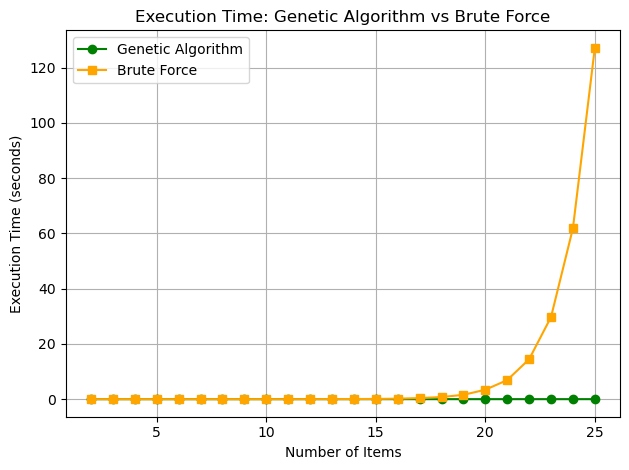

In [263]:
plt.plot(num_items[:-1], ga_time_stamps[:-1], marker='o', label='Genetic Algorithm', color='green')
plt.plot(num_items[:-1], bf_time_stamps[:-1], marker='s', label='Brute Force', color='orange')
plt.xlabel("Number of Items")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time: Genetic Algorithm vs Brute Force")
plt.legend()
plt.grid(True)
plt.tight_layout()